# Train models

* **Last Modified**: 07-04-2021
* **Authors**: Sam Budd, Gonzalo Mateo-García
---

> Tutorial: Train a Flood Extent segmentation model using the *WorldFloods* dataset

[1] Mateo-Garcia, G. et al. Towards global flood mapping onboard low cost satellites with machine learning. _Scientific Reports 11, 7249_ (2021).

This tutorial has been adapted for the **Artificial Inteligence for Earth Monitoring** online course which is available in the [FutureLearn platform](https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring).

**Note**: If you run this notebook in Google Colab change the running environment to use a GPU.

In [2]:
!pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

  Cloning https://github.com/spaceml-org/ml4floods to /tmp/pip-install-q5ywcoez/ml4floods_f06c65d6f6d34d71a9751391c66c9b01
  Running command git clone -q https://github.com/spaceml-org/ml4floods /tmp/pip-install-q5ywcoez/ml4floods_f06c65d6f6d34d71a9751391c66c9b01


In [2]:
import os

### Step 0: Download the training data

In order to run this tutorial you need (at least a subset of) the *WorldFloods* dataset. For this tutorial we will get it from our [public Google Drive folder](https://drive.google.com/folderview?id=1dqFYWetX614r49kuVE3CbZwVO6qHvRVH). For other alternatives see [the download *WorldFloods* documentation](./worldfloods_dataset.md).

### Step 0a: mount the Public folder if you are in Google Colab
If you're running this tutorial in Google Colab you need to *‘add a shortcut to your Google Drive’* from the [public Google Drive folder](https://drive.google.com/folderview?id=1dqFYWetX614r49kuVE3CbZwVO6qHvRVH) and mount that directory with the following code:

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    public_folder = '/content/drive/My Drive/Public WorldFloods Dataset'
    assert os.path.exists(public_folder), "Add a shortcut to the publice Google Drive folder: https://drive.google.com/drive/u/0/folders/1dqFYWetX614r49kuVE3CbZwVO6qHvRVH"
    google_colab = True
except ImportError as e:
    print(e)
    print("Setting google colab to false, it will need to install the gdown package!")
    public_folder = '.'
    google_colab = False

No module named 'google.colab'


### Step 0b: Unzip the worldfloods sample folder

If the folder could not be mounted it tries download the data using the `gdown` package (if not installed run: `pip install gdown`).

In [2]:
from ml4floods.models import dataset_setup
import zipfile

# Unzip the data
path_to_dataset_folder = "."
dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")

try:
    dataset_setup.validate_worldfloods_data(dataset_folder)
except FileNotFoundError as e:
    print(e)
    zip_file_name = os.path.join(public_folder, "worldfloods_v1_0_sample.zip") # this file size is 12.7Gb

    print("We need to unzip the data")
    # Download the zip file
    if not os.path.exists(zip_file_name):
        print("Download the data from Google Drive")
        import gdown
        # https://drive.google.com/file/d/11O6aKZk4R6DERIx32o4mMTJ5dtzRRKgV/view?usp=sharing
        gdown.download(id="11O6aKZk4R6DERIx32o4mMTJ5dtzRRKgV", output=zip_file_name)

    print("Unzipping the data")
    with zipfile.ZipFile(zip_file_name, "r") as zip_ref:
        zip_ref.extractall(path_to_dataset_folder)
        zip_ref.close()

Data downloaded follows the expected format


### Step 1: Setup Configuration file

First we will load configuration file form `models/configurations/worldfloods_template.json` in the config file we specify many different hyperparameters to train the model; you could either use this or make a copy of it and modify the hyper-parameters that you want to try out.

In [3]:
from ml4floods.models.config_setup import get_default_config
import pkg_resources

# Set filepath to configuration files
# config_fp = 'path/to/worldfloods_template.json'
config_fp = pkg_resources.resource_filename("ml4floods","models/configurations/worldfloods_template.json")

config = get_default_config(config_fp)

Loaded Config for experiment:  worldfloods_demo_test
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4cc_data_lake',
                       'channel_configuration': 'all',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': 'worldfloods',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]}

### Step 1.a: Seed everything for reproducibility

In [4]:
from pytorch_lightning import seed_everything
# Seed
seed_everything(config.seed)

Global seed set to 12


12

### Step 1.b: Make it a unique experiment
The 'experiment_name' is used to specify the folder in which to save models and associated files

In [5]:
config.experiment_name = 'training_demo'

### Step 2: Setup Dataloader
* 'loader_type' can be one of 'local' which assumes the images are already saved locally, or 'bucket' which will load images directly from the bucket specified in 'bucket_id'. To load images from the bucket the `GOOGLE_APPLICATION_CREDENTIALS` and `GS_USER_PROJECT` env variables must be set. If set to 'local' and the dataset is not found in the path `config.data_params.path_to_splits` it will trigger the download of the data.
* The *WorldFloods* dataset contains 264.29GB of data. We can load a subset of this by using a custom `train_test_split_sample.json` which will only download a subset of the training dataset and the validation and test sets.

In [6]:
%%time

from ml4floods.models.dataset_setup import get_dataset

config.data_params.batch_size = 16 # control this depending on the space on your GPU!
config.data_params.loader_type = 'local'
config.data_params.path_to_splits = dataset_folder # local folder to download the data
config.data_params.train_test_split_file = None

# If files are not in config.data_params.path_to_splits this will trigger the download of the products.
dataset = get_dataset(config.data_params)

train_test_split_file not provided. We will use the content in the folder ./worldfloods_v1_0_sample
train 6298  tiles
val 1284  tiles
test 11  tiles
CPU times: user 98.1 ms, sys: 4.63 ms, total: 103 ms
Wall time: 169 ms


#### Show some images from the dataloader

The dataset object is a [pytorch_lightining DataModule object](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.core.datamodule.html). This object has the *WorldFloods* train, val and test datasets as attributes (`dataset.train_dataset`, `dataset.val_dataset` and `dataset.test_dataset`). In addition we can create pytorch DataLoaders from them using the methods `train_dataloader()`, `val_dataloader()` and `test_dataloader()`.

In [7]:
train_dl = dataset.train_dataloader()

train_dl_iter = iter(train_dl)
batch = next(train_dl_iter)

batch["image"].shape, batch["mask"].shape

(torch.Size([16, 13, 256, 256]), torch.Size([16, 1, 256, 256]))

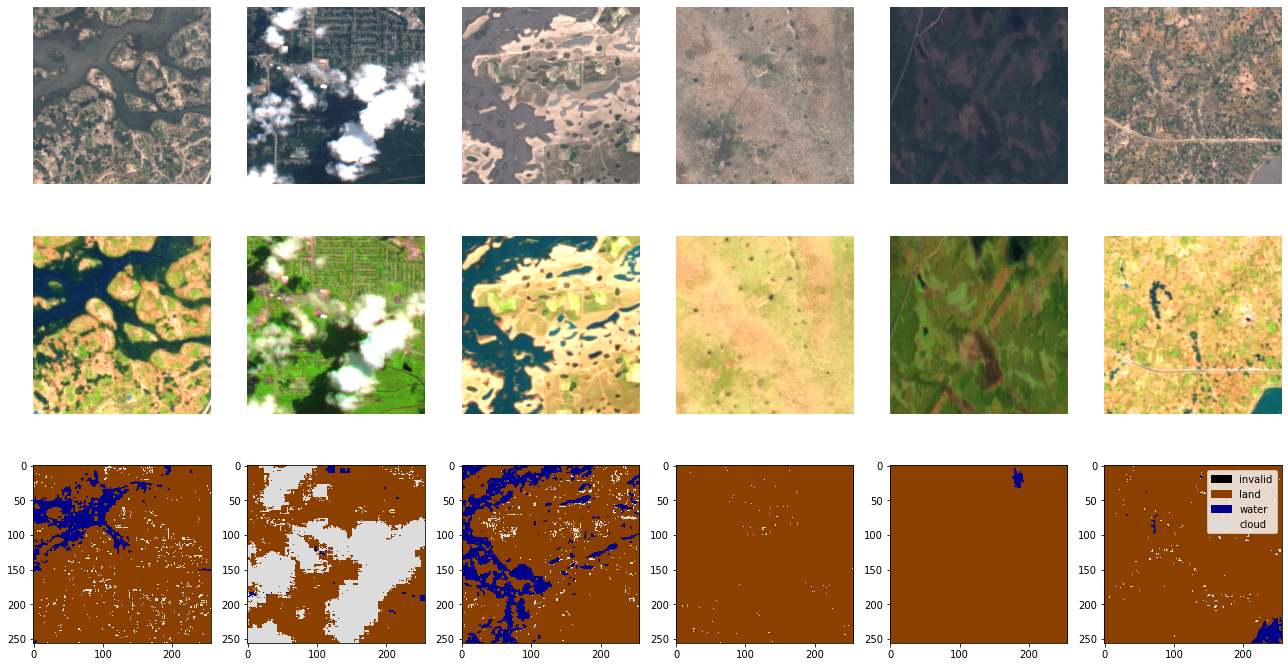

In [8]:
from ml4floods.models import worldfloods_model
import matplotlib.pyplot as plt

n_images=6
fig, axs = plt.subplots(3,n_images, figsize=(18,10),tight_layout=True)
worldfloods_model.plot_batch(batch["image"][:n_images],axs=axs[0],max_clip_val=3500.)
worldfloods_model.plot_batch(batch["image"][:n_images],bands_show=["B11","B8", "B4"],
                             axs=axs[1],max_clip_val=4500.)
worldfloods_model.plot_batch_output_v1(batch["mask"][:n_images, 0],axs=axs[2], show_axis=True)

### Step 3: Setup Model
     - 'train' = True specifies that we are training a new model from scratch
     - get_model(args) constructs a pytorch lightning model using the configuration specified in 'config.model_params'

In [9]:
 # folder to store the trained model (it will create a subfolder with the name of the experiment)
config.model_params

{'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
 'model_version': 'v1',
 'hyperparameters': {'max_tile_size': 256,
  'metric_monitor': 'val_dice_loss',
  'channel_configuration': 'all',
  'label_names': ['land', 'water', 'cloud'],
  'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
  'model_type': 'linear',
  'num_classes': 3,
  'max_epochs': 10,
  'val_every': 1,
  'lr': 0.0001,
  'lr_decay': 0.5,
  'lr_patience': 2,
  'early_stopping_patience': 4,
  'num_channels': 13},
 'train': True,
 'test': True}

In [10]:
from ml4floods.models.model_setup import get_model

config.model_params.model_folder = "models" 
os.makedirs("models", exist_ok=True)
config.model_params.test = False
config.model_params.train = True
config.model_params.hyperparameters.model_type = "simplecnn" # Currently implemented: simplecnn, unet, linear
model = get_model(config.model_params)
model

WorldFloodsModel(
  (network): SimpleCNN(
    (conv): Sequential(
      (0): Sequential(
        (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### Step 4:  (Optional) Set up Weights and Biases Logger for experiment
We pass this to the model trainer in a later cell to automaticall log relevant metrics to wandb

In [11]:
setup_weights_and_biases = False
if setup_weights_and_biases:
    import wandb
    from pytorch_lightning.loggers import WandbLogger

    # UNCOMMENT ON FIRST RUN TO LOGIN TO Weights and Biases (only needs to be done once)
    # wandb.login()
    # run = wandb.init()

    # Specifies who is logging the experiment to wandb
    config['wandb_entity'] = 'ml4floods'
    # Specifies which wandb project to log to, multiple runs can exist in the same project
    config['wandb_project'] = 'worldfloods-notebook-demo-project'

    wandb_logger = WandbLogger(
        name=config.experiment_name,
        project=config.wandb_project, 
        entity=config.wandb_entity
    )
else:
    wandb_logger = None

### Step 5: Setup Lightning Callbacks
* We implement checkpointing using the ModelCheckpoint callback to save the best performing checkpoints to local/gcs storage
* We implement early stopping using the EarlyStopping callback to stop training early if there is no performance improvement after 10 epochs from the latest best checkpoint

In [13]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

experiment_path = f"{config.model_params.model_folder}/{config.experiment_name}"

checkpoint_callback = ModelCheckpoint(
    dirpath=f"{experiment_path}/checkpoint",
    save_top_k=True,
    verbose=True,
    monitor='val_dice_loss',
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='val_dice_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)

callbacks = [checkpoint_callback, early_stop_callback]

print(f"The trained model will be stored in {config.model_params.model_folder}/{config.experiment_name}")

The trained model will be stored in models/training_demo


### Step 6: Setup Lighting Trainer
    -- Pytorch Lightning Trainer handles all the rest of the model training for us!
    -- add flags from 
    https://pytorch-lightning.readthedocs.io/en/0.7.5/trainer.html 

In [15]:
from pytorch_lightning import Trainer

config.gpus = '0'  # which gpu to use
# config.gpus = None # to not use GPU

config.model_params.hyperparameters.max_epochs = 4 # train for maximum 4 epochs

trainer = Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    callbacks=callbacks,
    default_root_dir=f"{config.model_params.model_folder}/{config.experiment_name}",
    accumulate_grad_batches=1,
    gradient_clip_val=0.0,
    auto_lr_find=False,
    benchmark=False,
    gpus=config.gpus,
    max_epochs=config.model_params.hyperparameters.max_epochs,
    check_val_every_n_epoch=config.model_params.hyperparameters.val_every,
    log_gpu_memory=None,
    resume_from_checkpoint=None
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/gonzalo/miniconda3/envs/ml4floods/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1580: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


### Start Training!

In [14]:
trainer.fit(model, dataset)

wandb: Currently logged in as: ipl_uv (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name    | Type      | Params
--------------------------------------
0 | network | SimpleCNN | 266 K 
--------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.065     Total estimated model params size (MB)
/opt/miniconda3/envs/ml4floods/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 393: val_dice_loss reached 0.60017 (best 0.60017), saving model to "/home/gonzalo/ml4floods/jupyterbook/content/ml4ops/models/training_demo/checkpoint/epoch=0-step=393.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 787: val_dice_loss reached 0.59220 (best 0.59220), saving model to "/home/gonzalo/ml4floods/jupyterbook/content/ml4ops/models/training_demo/checkpoint/epoch=1-step=787.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 1181: val_dice_loss reached 0.56052 (best 0.56052), saving model to "/home/gonzalo/ml4floods/jupyterbook/content/ml4ops/models/training_demo/checkpoint/epoch=2-step=1181-v1.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 1575: val_dice_loss reached 0.55334 (best 0.55334), saving model to "/home/gonzalo/ml4floods/jupyterbook/content/ml4ops/models/training_demo/checkpoint/epoch=3-step=1575.ckpt" as top True


1

### Step 7: Eval model

#### Plot some images and predictions

In [26]:
# Run inference on the images shown before
import torch

logits = model(batch["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")
prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")

Shape of logits: torch.Size([16, 3, 256, 256])
Shape of probs: torch.Size([16, 3, 256, 256])
Shape of prediction: torch.Size([16, 256, 256])


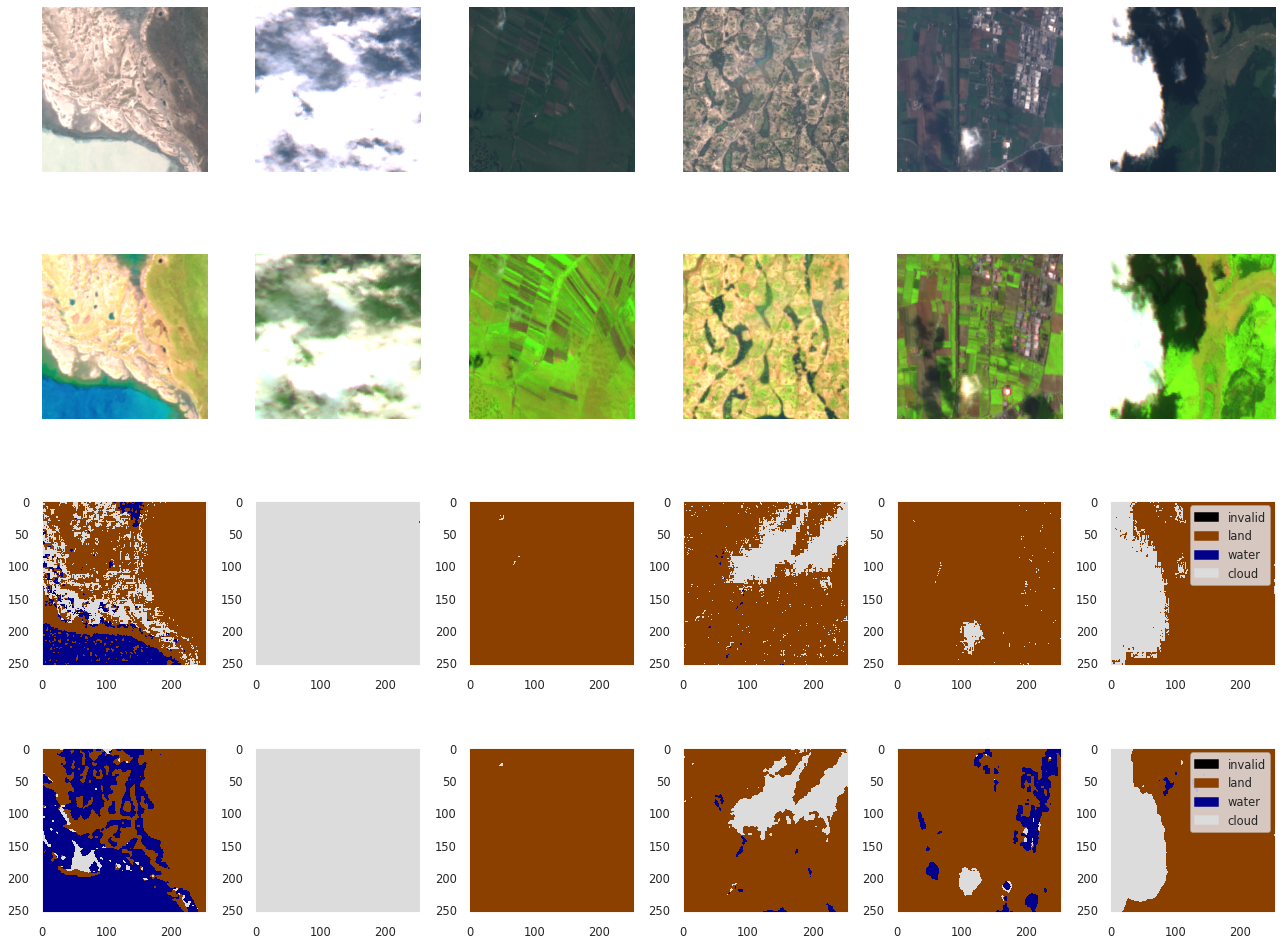

In [29]:

n_images=6
fig, axs = plt.subplots(4, n_images, figsize=(18,14),tight_layout=True)
worldfloods_model.plot_batch(batch["image"][:n_images],axs=axs[0],max_clip_val=3500.)
worldfloods_model.plot_batch(batch["image"][:n_images],bands_show=["B11","B8", "B4"],
                             axs=axs[1],max_clip_val=4500.)
worldfloods_model.plot_batch_output_v1(batch["mask"][:n_images, 0],axs=axs[2], show_axis=True)
worldfloods_model.plot_batch_output_v1(prediction[:n_images] + 1,axs=axs[3], show_axis=True)

for ax in axs.ravel():
    ax.grid(False)

#### Eval in the val dataset

Getting model inference function
Max tile size: 256


81it [00:52,  1.55it/s]                        


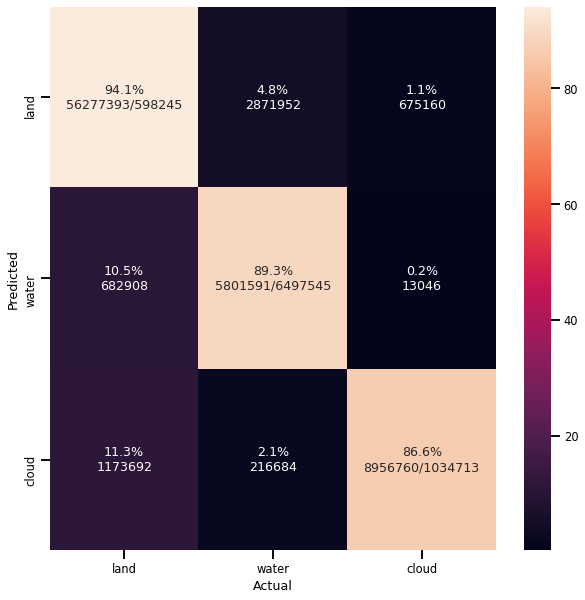

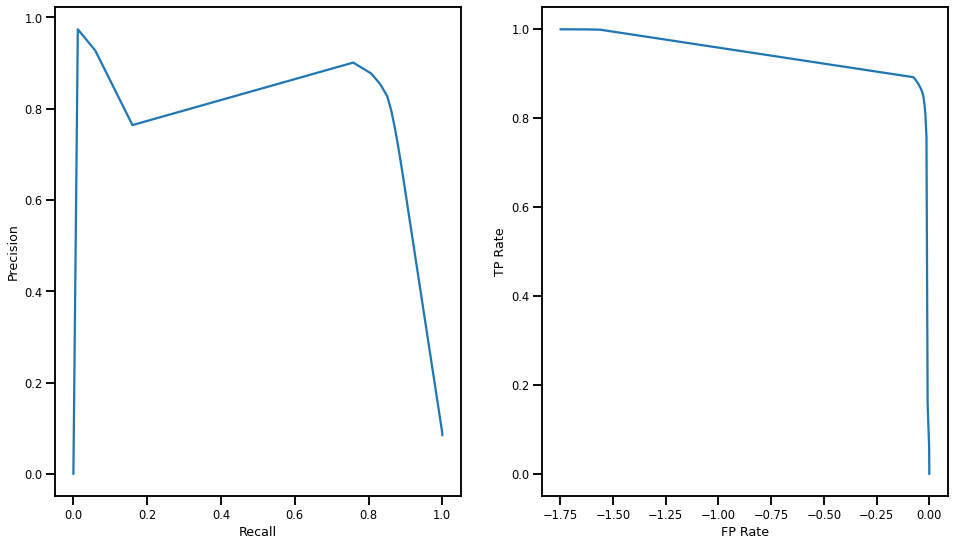

Per Class IOU {
    "cloud": 0.8116431733608086,
    "land": 0.9123927497732395,
    "water": 0.605203573769534
}


In [15]:
import torch
import numpy as np
from ml4floods.models.utils import metrics
from ml4floods.models.model_setup import get_model_inference_function
import pandas as pd

config.model_params.max_tile_size = 1024

inference_function = get_model_inference_function(model, config, apply_normalization=False, 
                                                  activation="softmax",
                                                  device=torch.device("cuda"))

dl = dataset.val_dataloader() # pytorch Dataloader

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    thresholds_water=thresholds_water, 
    convert_targets=False,
    plot=False)

label_names = ["land", "water", "cloud"]
metrics.plot_metrics(mets, label_names)

#### Show results for each flood event in the validation dataset

In [16]:
if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in ["land", "water", "cloud"]]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in ["land", "water", "cloud"]]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

Mean values across flood events: {'Recall_land': 93.08255820002643, 'Recall_water': 81.45670619858558, 'Recall_cloud': 76.05831858902059, 'IoU_land': 90.55111450826736, 'IoU_water': 53.68072319568316, 'IoU_cloud': 64.91956034880197}


,Recall_land,Recall_water,Recall_cloud,IoU_land,IoU_water,IoU_cloud
code,,,,,,
EMSR271,75.652827,97.856891,93.792703,75.435118,24.420104,70.859015
EMSR279,89.994390,78.400188,85.984087,83.700250,32.200438,81.255267
EMSR280,99.209005,91.197996,61.264703,97.885050,86.735377,49.392122
EMSR287,99.548484,73.487523,35.077289,98.816743,64.139818,17.221249
RS2,95.479942,84.557994,87.650254,91.563623,56.458526,82.770675
ST1,98.610701,63.239645,92.580875,95.905902,58.130076,88.019034


### Step 8: Save trained model

Save model to local/gcs along with configuration file used to conduct training!

In [17]:
import torch
from pytorch_lightning.utilities.cloud_io import atomic_save
from ml4floods.models.config_setup import save_json

# Save in the cloud and in the wandb logger save dir
atomic_save(model.state_dict(), f"{experiment_path}/model.pt")
# Save cofig file in experiment_path
config_file_path = f"{experiment_path}/config.json"
save_json(config_file_path, config)

#### Optional: Save weights and biases model and finish connection

In [18]:
if setup_weights_and_biases:
    torch.save(model.state_dict(), os.path.join(wandb_logger.save_dir, 'model.pt'))
    wandb.save(os.path.join(wandb_logger.save_dir, 'model.pt')) # Copy weights to weights and biases server
    wandb.finish()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


_runtime,619
_timestamp,1617872011
_step,1575
loss,0.76066
epoch,3
val_bce_loss,1.32021
val_dice_loss,0.55334
val_recall land,0.93818
val_recall water,0.84217
val_recall cloud,0.6011
val_iou land,0.89992


_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
loss,██▄▄▂▂▁▄▄▄▄▁▁▂▂▂▂▂▂▂▂▃▃▃▃▁▁▃▃▂▂
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆█████████
val_bce_loss,▅▁█▃
val_dice_loss,█▇▂▁
val_recall land,▄▁█▆
val_recall water,██▁▃
val_recall cloud,▁▄▇█
val_iou land,▁▁█▇


All Done - Now head to the Model Inference Tutorial to see how your model performed!